In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Loading data

In [2]:
df_pro_contacts_adults = pd.read_csv("pro_contacts_adults.csv", index_col=0)
df_pro_contacts_children = pd.read_csv("pro_contacts_children.csv", index_col=0)
df_households = pd.read_csv("households.csv", index_col=0)


#infos
print(df_households.sum())
#df_households.describe()
#df_pro_contacts_children.describe()
#df_pro_contacts_adults.describe()




nb_children                                                 3085
nb_adults                                                   6960
type           two_parent_familytwo_parent_familytwo_parent_f...
size                                                       10045
dtype: object


# Initializing the graph

We start by defining the classes whose instances will be the nodes of our graph

In [3]:
class Person():
    def __init__(self, person_id, state, age):
        self.person_id = person_id
        self.age = age
        self.state = state
    
    def __str__(self):
        s = "Person #{}".format(self.person_id)
        return(s)
    
    def __repr__(self):
        s = "Person #{}".format(self.person_id)
        return(s)

class Adult(Person):
    def __init__(self, person_id, state, job_cat, pro_contacts, company_id):
        super().__init__(person_id, state, "adult")
        self.job_cat = job_cat
        self.pro_contacts = pro_contacts
        self.company_id = company_id

class Child(Person):
    def __init__(self, person_id, state, school_contacts, school_id):
        super().__init__(person_id, state, "child")
        self.job_cat = job_cat
        self.school_contacts = school_contacts
        self.school_id = school_id

We create an empty graph into which we add nodes from the pro_contacts dataframes.

In [4]:
G = nx.Graph()
people = [] # we'll store Person objects here too in order to be able to access them quickly with person_id

for i, row in df_pro_contacts_adults.iterrows(): #We add adults to the nodes
    person_id = row.adult_id
    state = "S"
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    adult_node = Adult(person_id, state, job_cat, pro_contacts, company_id)
    G.add_node(adult_node)
    people.append(adult_node)
    
for i, row in df_pro_contacts_children.iterrows(): #We add childrens to the nodes
    person_id = row.child_id
    state = "S"
    school_contacts = row.school_contacts
    school_id = row.school_id
    
    child_node = Child(person_id, state, school_contacts, school_id)
    G.add_node(child_node)
    people.append(child_node)

    #print(G.nodes())
    


# Creating cliques for households

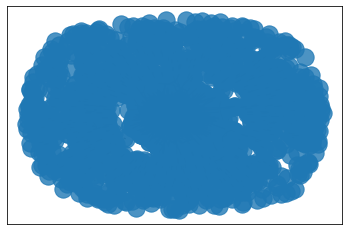

In [14]:
n_households = max(max(df_pro_contacts_children.index), max(df_pro_contacts_adults.index))
for id_household in range(n_households):
    df_household_adults = df_pro_contacts_adults.loc[df_pro_contacts_adults.index == id_household]
    household_adults = df_household_adults.adult_id
    
    df_household_children = df_pro_contacts_children.loc[df_pro_contacts_children.index == id_household]
    household_children = df_household_children.child_id
    
    household_people_ids = list(household_children) + list(household_adults)
    for edge in combinations(household_people_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "household"
        G[a][b]["id"] = id_household
        



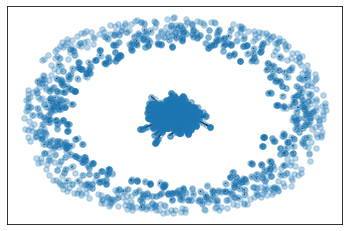

In [19]:
if (False):
    #pos = nx.spring_layout(G, iterations=20)
    nx.draw_networkx_nodes(G,pos,node_size=30 ,alpha =0.3)
    nx.draw_networkx_edges(G, pos)
    

# Creating cliques for companies

In [6]:
n_companies = int(max(df_pro_contacts_adults.company_id))
for company_id in range(n_companies):
    df_company = df_pro_contacts_adults.loc[df_pro_contacts_adults.company_id == company_id]
    company_employees_ids = list(df_company.adult_id)
    
    for edge in combinations(company_employees_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "company"
        G[a][b]["id"] = company_id

In [7]:
df_company

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
1087,2699,Services_other,1317,250.0
1619,4024,Services_other,201,250.0
2458,5009,Services_other,714,250.0


In [31]:
#calcule la position des nodes pour afficher le graph 
# /!\ très lent /!\
#pos = nx.spring_layout(G, iterations=60)


pos = nx.kamada_kawai_layout(G)


KeyboardInterrupt: 

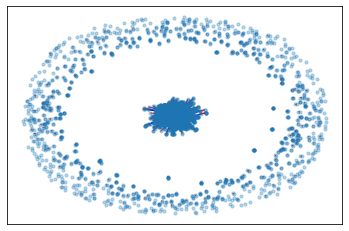

In [29]:
edge_color = []
for edge in G.edges():
    #print(edge)
    edge = G[edge[0]][edge[1]]
    if edge["type"] == "company":
        edge_color.append("b")
    if edge["type"] == "household":
        edge_color.append("r")
    

nx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)
nx.draw_networkx_edges(G, pos,edge_color = edge_color)

# Adding links for pro life outside the company

In [8]:
for i, row in df_pro_contacts_adults.iterrows():
    adult_id = row.adult_id
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    company_employees_ids = list(df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id) &\
                                                            (df_pro_contacts_adults.adult_id != adult_id)].adult_id)

    #TO DO
        
for i, row in df_pro_contacts_children.iterrows():
    child_id = row.child_id
    school_contacts = row.school_contacts
    school_id = row.school_id
    
#     scool_pupils_ids = list(df_pro_contacts_children.loc[(df_pro_contacts_children.school_id == school_id) & (df_pro_contacts_adults.adult_id != adult_id)].adult_id)
    # TO DO

In [9]:
df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id)]

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
506,1245,Shops_other,9,101.0
745,1829,Services_other,998,101.0
1844,4395,Shops_other,4,101.0
3775,6933,Shops_other,13,101.0
3801,6959,Services_other,870,101.0


In [10]:
pro_contacts

870

# Exporting the graph for visualization with Gephi

In [11]:
nx.write_gexf(G, "test.gexf")